# Multi-Layer Perceptron: Jane Street 2020

Using MLP to classify, the focus here is to establish the workflow and testing submission.


In [4]:
import os, sys
import gc
import random
import numpy as np
import pandas as pd
import seaborn as sns
import datatable as dtable
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
plt.style.use('dark_background') #plt.style.use('default')

globalSeed=67
np.random.seed(globalSeed) # for reproducibility

import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

# from tabulate import tabulate
# pdtabulate=lambda df:tabulate(df,headers='keys',tablefmt='psql')

pd.set_option('display.max_columns', 200)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [ ]:
# Suppressing warning before saving the presentation, only
import warnings
warnings.filterwarnings('ignore')

## 0. Load data

In [2]:
%%time
ddir='~/learn/kaggle/Data/JaneStreet20' # local
#ddir='../input/jane-street-market-prediction' # kaggle

# using datatable for faster loading
data = dtable.fread(os.path.join(ddir,"train.csv")).to_pandas()
features = pd.read_csv(os.path.join(ddir,"features.csv"))

gc.collect();

CPU times: user 42 s, sys: 3.3 s, total: 45.3 s
Wall time: 4.14 s


0

## 1.  Preprecessing

### 1.1 Handling NaN

NaN is handled in the following way
 - Within a day, NaN is replaced with value in previous row
 - The first row (trade) of any day is not changed. That is, NaN therein in not replaced
 - Drop a row if it contains any NaN
   - This mean dropping the row in training and validation
   - In testing, this implies to take no action (action=0)

### 1.2 Train-validation-test (TVT) split

Split will be performed in the following way
 - Split is performed on dates
 - Reserve a latest segment of days as test
 - Train-validation split is randomized selection of days
 - In training and validation, each row is considered independent

### 1.3 Centering and scaling

Centering and scaling is done on train set. Same scheme is applied to validation and test sets.


In [34]:
def fillNanWithinDay(df,dayCol,method='ffill',dropna=True):
    """fill NaN within date
    
    This function does (forward) fill without crossing dates. Equal value in dayCol column indicates same date.
    "Date" here can be generalized to block with equal dayCol value
    Parameter:
      df: dataframe
      dayCol: string, column name. Equal value indicates same date (block)
      method: fill method. Fill value does not cross block
      dropna: if True, drop NaN after ffill
    return:
      list of pd.DataFrame of day, NaN replaced
    """
    dayList=df[dayCol].unique()
    if dropna:
        dfList=[df.loc[df[dayCol]==val].fillna(method='ffill').dropna() for val in dayList]
    else:
        dfList=[df.loc[df[dayCol]==val].fillna(method='ffill') for val in dayList]
    return dfList
    
    

[Text(0.5, 0, 'Day'), Text(0, 0.5, '#Op remain')]

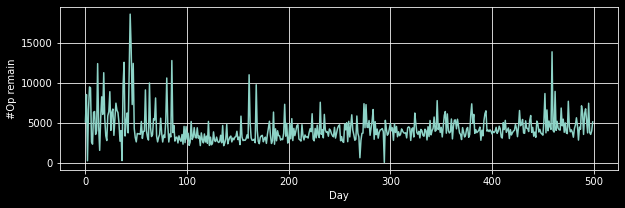

In [42]:
# 1.1 NaN

dataBlock=fillNanWithinDay(data,'date',method='ffill',dropna=True)
_, ax = plt.subplots(nrows=1, ncols=1,figsize=(10, 3))
ax.plot([len(dataBlock_1) for dataBlock_1 in dataBlock]); ax.grid()
ax.set(xlabel='Day',ylabel='#Op remain');

In [ ]:
# 1.2 TVT split



In [27]:
tt=pd.DataFrame(np.random.rand(7,3),columns=['a','b','c'])
tt.loc[0:2,'a']=1
tt.loc[3:,'a']=2
tt.loc[1,'c']=np.nan
tt.loc[4,'b']=np.nan

In [28]:
tt

,a,b,c
0,1.0,0.958017,0.549231
1,1.0,0.277251,NaN
2,1.0,0.040120,0.608177
3,2.0,0.416322,0.455667
4,2.0,NaN,0.503244
5,2.0,0.290923,0.432703
6,2.0,0.556313,0.127414


In [35]:
zz=fillNanWithinDay(tt,'a',method='ffill',dropna=True)

In [36]:
zz

[     a         b         c
 0  1.0  0.958017  0.549231
 1  1.0  0.277251  0.549231
 2  1.0  0.040120  0.608177,
      a         b         c
 3  2.0  0.416322  0.455667
 4  2.0  0.416322  0.503244
 5  2.0  0.290923  0.432703
 6  2.0  0.556313  0.127414]

In [6]:
data.columns

Index(['date', 'weight', 'resp_1', 'resp_2', 'resp_3', 'resp_4', 'resp',
       'feature_0', 'feature_1', 'feature_2',
       ...
       'feature_121', 'feature_122', 'feature_123', 'feature_124',
       'feature_125', 'feature_126', 'feature_127', 'feature_128',
       'feature_129', 'ts_id'],
      dtype='object', length=138)

In [25]:
dayList=data['date'].unique()

In [26]:
len(dayList)

500